In [1]:
"""
A minimal implementation of Monte Carlo tree search (MCTS) in Python 3
Luke Harold Miles, July 2019, Public Domain Dedication
See also https://en.wikipedia.org/wiki/Monte_Carlo_tree_search
https://gist.github.com/qpwo/c538c6f73727e254fdc7fab81024f6e1
"""
from collections import defaultdict
import math


class MCTS:
    """Monte Carlo tree searcher. First rollout the tree then choose
    a move.
    """
    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node):
        """Choose the best successor of node. (Choose a move in the game)
        """
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score)

    def do_rollout(self, node):
        """Make the tree one layer better. (Train for one iteration.)
        """
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        """Find an unexplored descendent of `node`
        """
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper

    def _expand(self, node):
        """Update the `children` dict with the children of `node`
        """
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    def _simulate(self, node):
        """Returns the reward for a random simulation (to completion)
        of `node`
        """
        invert_reward = True
        while True:
            if node.is_terminal():
                reward = node.reward()
                return 1 - reward if invert_reward else reward
            node = node.find_random_child()
            invert_reward = not invert_reward

    def _backpropagate(self, path, reward):
        """Send the reward back up to the ancestors of the leaf
        """
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = 1 - reward  # 1 for me is 0 for my enemy, and vice versa

    def _uct_select(self, node):
        """Select a child of node, balancing exploration & exploitation
        """
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = math.log(self.N[node])

        def uct(n):
            """Upper confidence bound for trees
            """
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(
                log_N_vertex / self.N[n]
            )

        return max(self.children[node], key=uct)


In [2]:
from abc import ABC, abstractmethod


class Node(ABC):
    """
    A representation of a single board state.
    MCTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """

    @abstractmethod
    def find_children(self):
        "All possible successors of this board state"
        return set()

    @abstractmethod
    def find_random_child(self):
        "Random successor of this board state (for more efficient simulation)"
        return None

    @abstractmethod
    def is_terminal(self):
        "Returns True if the node has no children"
        return True

    @abstractmethod
    def reward(self):
        "Assumes `self` is terminal node. 1=win, 0=loss, .5=tie, etc"
        return 0

    @abstractmethod
    def __hash__(self):
        "Nodes must be hashable"
        return 123456789

    @abstractmethod
    def __eq__(node1, node2):
        "Nodes must be comparable"
        return True


In [3]:
"""
An example implementation of the abstract Node class for use in MCTS
If you run this file then you can play against the computer.
A tic-tac-toe board is represented as a tuple of 9 values, each either None,
True, or False, respectively meaning 'empty', 'X', and 'O'.
The board is indexed by row:
0 1 2
3 4 5
6 7 8
For example, this game board
O - X
O X -
X - -
corrresponds to this tuple:
(False, None, True, False, True, None, True, None, None)
"""

from collections import namedtuple
from random import choice
#from monte_carlo_tree_search import MCTS, Node

_TTTB = namedtuple("TicTacToeBoard", "tup turn winner terminal")

# Inheriting from a namedtuple is convenient because it makes the class
# immutable and predefines __init__, __repr__, __hash__, __eq__, and others
class TicTacToeBoard(_TTTB, Node):
    def find_children(board):
        if board.terminal:  # If the game is finished then no moves can be made
            return set()
        # Otherwise, you can make a move in each of the empty spots
        return {
            board.make_move(i) for i, value in enumerate(board.tup) if value is None
        }

    def find_random_child(board):
        if board.terminal:
            return None  # If the game is finished then no moves can be made
        empty_spots = [i for i, value in enumerate(board.tup) if value is None]
        return board.make_move(choice(empty_spots))

    def reward(board):
        if not board.terminal:
            raise RuntimeError(f"reward called on nonterminal board {board}")
        if board.winner is board.turn:
            # It's your turn and you've already won. Should be impossible.
            raise RuntimeError(f"reward called on unreachable board {board}")
        if board.turn is (not board.winner):
            return 0  # Your opponent has just won. Bad.
        if board.winner is None:
            return 0.5  # Board is a tie
        # The winner is neither True, False, nor None
        raise RuntimeError(f"board has unknown winner type {board.winner}")

    def is_terminal(board):
        return board.terminal

    def make_move(board, index):
        tup = board.tup[:index] + (board.turn,) + board.tup[index + 1 :]
        turn = not board.turn
        winner = _find_winner(tup)
        is_terminal = (winner is not None) or not any(v is None for v in tup)
        return TicTacToeBoard(tup, turn, winner, is_terminal)

    def to_pretty_string(board):
        to_char = lambda v: ("X" if v is True else ("O" if v is False else " "))
        rows = [
            [to_char(board.tup[3 * row + col]) for col in range(3)] for row in range(3)
        ]
        return (
            "\n  1 2 3\n"
            + "\n".join(str(i + 1) + " " + " ".join(row) for i, row in enumerate(rows))
            + "\n"
        )


def play_tic_tac_toe():
    tree = MCTS()
    board = new_tic_tac_toe_board()
    print(board.to_pretty_string())
    while True:
        row_col = input("enter row,col: ")
        row, col = map(int, row_col.split(","))
        index = 3 * (row - 1) + (col - 1)
        if board.tup[index] is not None:
            raise RuntimeError("Invalid move")
        board = board.make_move(index)
        print(board.to_pretty_string())
        if board.terminal:
            break
        # You can train as you go, or only at the beginning.
        # Here, we train as we go, doing fifty rollouts each turn.
        for _ in range(50):
            tree.do_rollout(board)
        board = tree.choose(board)
        print(board.to_pretty_string())
        if board.terminal:
            break


def _winning_combos():
    for start in range(0, 9, 3):  # three in a row
        yield (start, start + 1, start + 2)
    for start in range(3):  # three in a column
        yield (start, start + 3, start + 6)
    yield (0, 4, 8)  # down-right diagonal
    yield (2, 4, 6)  # down-left diagonal


def _find_winner(tup):
    "Returns None if no winner, True if X wins, False if O wins"
    for i1, i2, i3 in _winning_combos():
        v1, v2, v3 = tup[i1], tup[i2], tup[i3]
        if False is v1 is v2 is v3:
            return False
        if True is v1 is v2 is v3:
            return True
    return None


def new_tic_tac_toe_board():
    return TicTacToeBoard(tup=(None,) * 9, turn=True, winner=None, terminal=False)


In [9]:
pip install python-chess

Note: you may need to restart the kernel to use updated packages.


In [10]:
import chess

In [11]:
import hashlib
import copy

_TTTB = namedtuple('ChessGame', 'board')

# Inheriting from a namedtuple is convenient because it makes the class
# immutable and predefines __init__, __repr__, __hash__, __eq__, and others
class ChessGame(_TTTB, Node):
    def find_children(self):
        if self.is_terminal():
            return set()
        return {
            self.make_move(m) for m in self.board.legal_moves
        }

    def find_random_child(self):
        if self.is_terminal():
            return None  # If the game is finished then no moves can be made
        moves = list(self.board.legal_moves)
        m = choice(moves)
        # print(m)
        return self.make_move(m)

    def player_win(self, turn):
        if self.board.result() == '1-0' and turn:
            return True
        if self.board.result() == '0-1' and not turn:
            return True
        return False

    def debug(self):
        print('\n{self.board}')
        print([str(m) for m in self.board.move_stack])
    
    def reward(self):
        if not self.is_terminal():
            raise RuntimeError(f'reward called on nonterminal board {self.board}')
        if self.board.result() == '1/2-1/2':
            return 0.5
        if self.player_win(not self.board.turn):
            return 0.0  # Your opponent has just won. Bad.
        if self.player_win(self.board.turn):
            # It's your turn and you've already won. Should be impossible.
            raise RuntimeError(f'reward called on unreachable board \n{self.board}')
        # The winner is neither True, False, nor None
        #return random.random()
        # return 0.0
        self.debug()
        raise RuntimeError(f'board has unknown winner type!')

    def make_move(self, move):
        child = self.board.copy()
        child.push(move)
        return ChessGame(child)
    
    def is_terminal(self):
        return self.board.is_game_over()
    
    def __hash__(self):
        "Nodes must be hashable"
        return int(
            hashlib.md5(
                self.board.fen().encode('utf-8')
            ).hexdigest()[:8],
            16
        )
    
    def __eq__(self, other):
        "Nodes must be comparable"
        return self.__hash__() == other.__hash__()

    def __repr__(self):
        return '\n' + str(self.board)

In [12]:
from IPython.display import display
import chess
import chess.svg


def play_chess():
    tree = MCTS()
    game = ChessGame(chess.Board())
    display(chess.svg.board(board=game.board, size=300))

    while True:
        move_str = input('enter move: ')
        move = chess.Move.from_uci(move_str)
        if move not in list(game.board.legal_moves):
            raise RuntimeError('Invalid move')
        game = game.make_move(move)
        display(chess.svg.board(board=game.board, size=300))
        if game.is_terminal():
            break
        # You can train as you go, or only at the beginning.
        # Here, we train as we go, doing fifty rollouts each turn.
        for _ in range(50):
            tree.do_rollout(game)
        game = tree.choose(game)
        print(game)
        if game.is_terminal():
            break

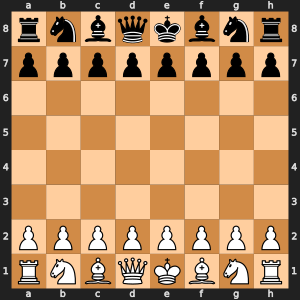

enter move: a2a4


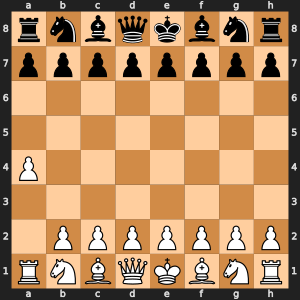


r n b q k b n r
. p p p p p p p
. . . . . . . .
p . . . . . . .
P . . . . . . .
. . . . . . . .
. P P P P P P P
R N B Q K B N R


In [ ]:
play_chess()